# Forward-Forward Algorithm

* [**Paper**](https://arxiv.org/abs/2212.13345)

The paper suggests that instead of minimising a global loss function (i.e. across the entire network), we can minimise local loss functions (one per layer). These loss functions are the negative log-likelihood of the Bernoulli random variable $Y$, which is defined as:

$$
Y = \begin{cases}
1 \quad \text{if } \mathbf{X} \text{ is "real"} \\
0 \quad \text{otherwise}
\end{cases}
$$

i.e. we are trying to maximise $p(Y | \mathbf{X})$, which is defined as:

$$\begin{align}
p(Y | \mathbf{X}) &= \frac{1}{1 + \exp(-u)} \\
u &= \mathbf{z}^T \mathbf{z} - \theta \\
\mathbf{z} &= f\left(\mathbf{W}_l\mathbf{X} + \mathbf{b}_l\right)
\end{align}$$

where $\mathbf{X}_l$ and $\mathbf{b}_l$ are the weights and biases of layer $l$, respectively, $f$ is an element-wise non-linear function (e.g. ReLU), and $\theta$ is some threshold. But what does "real" data mean in this context? The paper also refers to it as "positive" data (conversely "negative" data is fake), and in the simple case of MNIST it basically means corrupted images.

In [1]:
import flax.linen as nn
import jax
import jax.numpy as jnp
import jax.random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tqdm
from sklearn import metrics

In [12]:
def kaiming(n):
    return jnp.sqrt(2 / n)

def init_layer(shape, rng):
    s = kaiming(shape[-1])
    
    kW, kb = jax.random.split(rng)
    W = s * jax.random.normal(kW, shape)
    b = s * jax.random.normal(kb, shape[-1:])
    return W, b

In [48]:
def nll(t, u):
    # using the log sigmoid for stability
    log_p = nn.log_sigmoid(u)
    return - jnp.mean(log_p - u * (1 - t))


def forward(w, X, t):
    W, b = w
    z = nn.relu(X @ W + b)

    ll = nll(t, jnp.sum(z ** 2, axis=-1) - 10)
    return ll, z


@jax.jit
def train_step(w, X, t, eta):
    f = jax.value_and_grad(forward, has_aux=True)
    G = ()
    L = jnp.array(0)
    for (W, b) in w:
        (l, X), g = f((W, b), X, t)
        G = (*G, g)
        L += l

    return update_params(w, G, eta), L

    
def update_params(w, G, eta):
    return jax.tree_map(lambda W, g: W - eta * g, w, G)

In [5]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X_train = jnp.array(X_train.reshape(len(X_train), -1) / 126)
X_test = jnp.array(X_test.reshape(len(X_test), -1) / 126)

y_train = jnp.array(y_train)
y_test = jnp.array(y_test)

In [9]:
def get_batch_indices(rng, dataset_size, batch_size):
    steps_per_epoch = dataset_size // batch_size

    perms = jax.random.permutation(rng, dataset_size)
    perms = perms[:steps_per_epoch * batch_size]  # skip incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size))
    return perms

In [10]:
rng = jax.random.PRNGKey(0)

In [13]:
p0 = ()
r = rng
for l in [
    (28 ** 2, 512),
    (512, 256),
    (256, 64)
]:
    r, r0 = jax.random.split(r)
    p0 = (*p0, init_layer(l, r0))

In [17]:
def create_negative_examples(X, rng):
    k0, k1, k2 = jax.random.split(rng, 3)
    p0 = jax.random.permutation(k0, len(X))
    p1 = jax.random.permutation(k1, len(X))

    m = jax.random.bernoulli(k2, 0.3, X.shape)
    return m * X[p0] + (1 - m) * X[p1]


In [60]:
p = p0
r = rng

E = 50
X = jnp.concatenate((X_train, create_negative_examples(X_train, rng)))
t = jnp.array([1] * len(X_train) + [0] * len(X_train))
for e in range(E):
    r, r0 = jax.random.split(r)
    ix = get_batch_indices(r0, len(X), 128)

    L = jnp.array(0)
    for i in tqdm.tqdm(ix, desc=f"Epoch {e}"):
        p, l = train_step(p, X[i], t[i], eta=1e-3)
        L += l
    print(f"Mean epoch loss: {(L / len(ix)).item():.3f}")

Epoch 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:04<00:00, 222.63it/s]


Mean epoch loss: 9.074


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:04<00:00, 220.08it/s]


Mean epoch loss: 2.904


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:04<00:00, 196.60it/s]


Mean epoch loss: 2.332


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:05<00:00, 184.85it/s]


Mean epoch loss: 2.041


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:05<00:00, 171.23it/s]


Mean epoch loss: 1.854


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:05<00:00, 168.98it/s]


Mean epoch loss: 1.718


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:05<00:00, 157.65it/s]


Mean epoch loss: 1.612


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:06<00:00, 153.78it/s]


Mean epoch loss: 1.526


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:06<00:00, 149.93it/s]


Mean epoch loss: 1.456


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:06<00:00, 153.33it/s]


Mean epoch loss: 1.396


Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:06<00:00, 152.28it/s]


Mean epoch loss: 1.343


Epoch 11: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:06<00:00, 154.77it/s]


Mean epoch loss: 1.296


Epoch 12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:05<00:00, 158.99it/s]


Mean epoch loss: 1.254


Epoch 13: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:05<00:00, 167.09it/s]


Mean epoch loss: 1.217


Epoch 14: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:05<00:00, 169.37it/s]


Mean epoch loss: 1.181


Epoch 15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:05<00:00, 168.13it/s]


Mean epoch loss: 1.150


Epoch 16: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:05<00:00, 169.55it/s]


Mean epoch loss: 1.122


Epoch 17: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:05<00:00, 169.00it/s]


Mean epoch loss: 1.094


Epoch 18: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:05<00:00, 169.85it/s]


Mean epoch loss: 1.069


Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:05<00:00, 171.18it/s]


Mean epoch loss: 1.045


Epoch 20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:05<00:00, 170.49it/s]


Mean epoch loss: 1.022


Epoch 21: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:05<00:00, 170.54it/s]


Mean epoch loss: 1.001


Epoch 22: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:05<00:00, 171.43it/s]


Mean epoch loss: 0.982


Epoch 23: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:05<00:00, 171.27it/s]


Mean epoch loss: 0.963


Epoch 24: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:05<00:00, 169.60it/s]


Mean epoch loss: 0.945


Epoch 25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:05<00:00, 172.11it/s]


Mean epoch loss: 0.928


Epoch 26: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:05<00:00, 164.28it/s]


Mean epoch loss: 0.912


Epoch 27: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:05<00:00, 162.54it/s]


Mean epoch loss: 0.897


Epoch 28: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:05<00:00, 157.78it/s]


Mean epoch loss: 0.882


Epoch 29: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:05<00:00, 158.28it/s]


Mean epoch loss: 0.868


Epoch 30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:05<00:00, 158.86it/s]


Mean epoch loss: 0.855


Epoch 31: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:05<00:00, 168.20it/s]


Mean epoch loss: 0.842


Epoch 32: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:05<00:00, 171.55it/s]


Mean epoch loss: 0.830


Epoch 33: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:05<00:00, 174.46it/s]


Mean epoch loss: 0.818


Epoch 34: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:05<00:00, 180.98it/s]


Mean epoch loss: 0.807


Epoch 35: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:05<00:00, 184.93it/s]


Mean epoch loss: 0.795


Epoch 36: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:05<00:00, 183.25it/s]


Mean epoch loss: 0.785


Epoch 37: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:05<00:00, 184.13it/s]


Mean epoch loss: 0.775


Epoch 38: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:05<00:00, 183.51it/s]


Mean epoch loss: 0.764


Epoch 39: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:05<00:00, 183.67it/s]


Mean epoch loss: 0.755


Epoch 40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:05<00:00, 184.13it/s]


Mean epoch loss: 0.746


Epoch 41: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:05<00:00, 183.66it/s]


Mean epoch loss: 0.737


Epoch 42: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:04<00:00, 188.74it/s]


Mean epoch loss: 0.728


Epoch 43: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:05<00:00, 186.42it/s]


Mean epoch loss: 0.720


Epoch 44: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:05<00:00, 183.15it/s]


Mean epoch loss: 0.712


Epoch 45: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:05<00:00, 183.68it/s]


Mean epoch loss: 0.704


Epoch 46: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:05<00:00, 174.86it/s]


Mean epoch loss: 0.696


Epoch 47: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:05<00:00, 167.99it/s]


Mean epoch loss: 0.688


Epoch 48: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:05<00:00, 171.35it/s]


Mean epoch loss: 0.681


Epoch 49: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [00:05<00:00, 165.75it/s]

Mean epoch loss: 0.673


In [61]:
from sklearn import manifold


def mlp(w, X):
    for (W, b) in w:
        X = nn.relu(X @ W + b)
    return X

In [62]:
T = manifold.TSNE(n_components=2, random_state=42).fit_transform(
    np.array(mlp(p, X_test))
)

<AxesSubplot: xlabel='t0', ylabel='t1'>

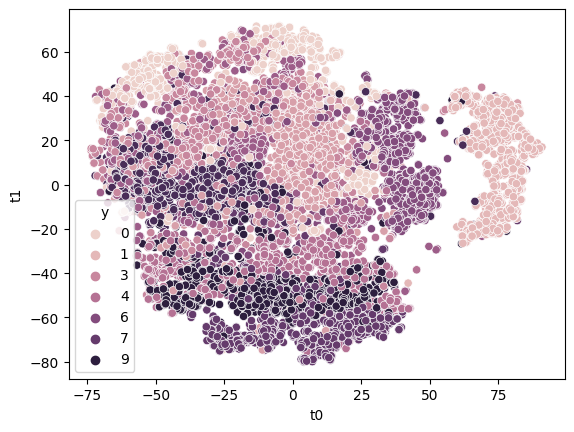

In [63]:
sns.scatterplot(
    data=pd.DataFrame(T, columns=["t0", "t1"])
    .assign(y=y_test),
    x="t0",
    y="t1",
    hue="y"
)

## Appendix

Some additional derivations (for my own benefit)

### Negative log-likelihood

The likelihood $p(x)$ of a Bernoulli random variable $x$ is defined as:

$$
p(x) = \prod_x \mu^x (1 - \mu)^{1 - x}
$$

Thus, the log-likelihood is:

$$
\log p(x) = \sum_x x \log \mu  + (1 - x) \log (1 - \mu)
$$

Since $x \in \{0, 1\}$, we get:

$$
\log p(x) = x \log \mu + (1 - x) \log (1 - \mu)
$$

We have:

$$\begin{align}
\mu &= \frac{\exp(z)}{1 + \exp(z)} = \frac{1}{1 + \exp(-z)} \\
1 - \mu &= \frac{(1 + \exp(-z)) - 1}{1 + \exp(-z)} = \frac{exp(-z)}{1 + \exp(-z)}
\end{align}$$

Hence:

$$\begin{align}
\log \mu &= - \log \left(1 + \exp(-z) \right) \\
\log (1 - \mu) &= -z - \log \left(1 + \exp(-z) \right)
\end{align}$$

And thus:

$$
\log(1 - \mu) = \log \mu - z
$$

And finally:

$$
\log p(x) = \log \mu - z (1 - x)
$$

i.e. when $x = 0$, we need to subtract $z$ from $\log \mu$. Otherwise, we just take $\log \mu$